# Overfitting, Regularization, and Information Criteria

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import theano
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import statsmodels.formula.api as smf 
%matplotlib inline

In [3]:
sns.set()

## The Problem with Parameters

### 6.1

In [4]:
sppnames = ["afarensis", "africanus", "habilis", "boisei", "rudolfensis", "ergaster", "sapiens"]
brainvolcc = [438, 452, 612, 521, 752, 871, 1350]
masskg = [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]
d = pd.DataFrame({"species": sppnames,
                  "brain": brainvolcc,
                  "mass": masskg})

### 6.2

In [5]:
m6_1 = smf.ols("brain ~ mass", data=d).fit()

### 6.3

In [6]:
1 - m6_1.resid.var()/d["brain"].var()

0.490158047949084

### 6.4

In [7]:
m6_2 = smf.ols('brain ~ mass + I(mass**2)', data=d).fit()

### 6.5

In [8]:
m6_3 = smf.ols("brain ~ mass + I(mass**2) + I(mass**3)", data=d).fit()
m6_4 = smf.ols("brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4)", data=d).fit()
m6_5 = smf.ols("brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)", data=d).fit()
m6_6 = smf.ols("brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5) + I(mass**6)", data=d).fit()

### 6.6

In [9]:
m6_7 = smf.ols('brain ~ 1', data=d).fit()

### 6.7

In [10]:
d_new = d.drop(d.index[-1])

### 6.8

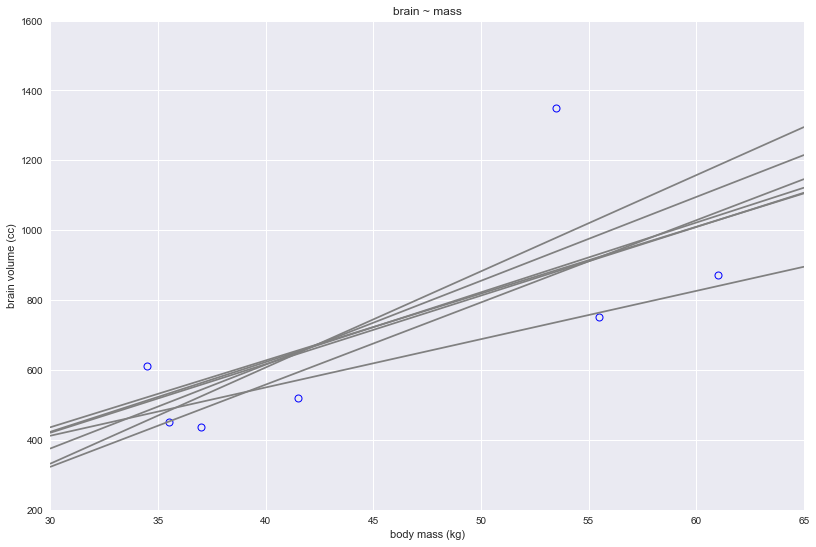

In [11]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
xs = pd.DataFrame({"mass": np.linspace(30, 65, 30)})

ax.plot(d["mass"], d["brain"], "o", mew=1.0, mec="b", mfc="None")
for i in range(len(d)):
    d_new = d.drop(d.index[i])
    m0 = smf.ols("brain ~ mass", data=d_new).fit()
    ax.plot(xs, m0.predict(xs), color="grey")

ax.set_xlim(30, 65)
ax.set_ylim(200, 1600)
ax.set_xlabel("body mass (kg)")
ax.set_ylabel("brain volume (cc)")
ax.set_title("brain ~ mass");

## Information Theory and Model Performance

### 6.9

In [12]:
p = np.array([0.3, 0.7])
-np.sum(p * np.log(p))

0.6108643020548935

### 6.10

In [13]:
m6_1 = smf.ols("brain ~ mass", data=d).fit()
-2 * m6_1.llf

94.92498968588757

### 6.11

In [14]:
d["mass_s"] = (d["mass"] - d["mass"].mean())/d["mass"].std()

with pm.Model() as m6_8:
    a = pm.Normal("a", mu=np.mean(d["brain"]), sd=10)
    b = pm.Normal("b", mu=0, sd=10)
    sigma = pm.Uniform("sigma", 0, np.std(d["brain"]) * 10)
    mu = pm.Deterministic("mu", a + b * d["mass_s"])
    brain = pm.Normal("brain", mu=mu, sd=sigma, observed=d["brain"])
    trace6_8 = pm.sample(draws=1000, tune=1000)
    
theta = pm.summary(trace6_8, varnames=["a", "b", "sigma"])["mean"]
dev = -2 * np.sum(stats.norm.logpdf(d["brain"], loc=theta["a"] + theta["b"]*d["mass_s"], scale=theta["sigma"]))
dev

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 853.07draws/s] 


100.22972080810402

### 6.12

Implementing [this](https://github.com/rmcelreath/rethinking/blob/a309712d904d1db7af1e08a76c521ab994006fd5/R/sim_train_test.R) function in python, but largely copying over from [here](https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb)

In [15]:
def sim_train_test(N=20, k=3, rho=[0.15, -0.14], b_sigma=100):
    n_dim = 1 + len(rho)

    if n_dim < k:
        rho = np.pad(rho, (0, k - n_dim), "constant")
        n_dim = k
    
    Rho = np.diag(np.ones(n_dim))
    Rho[0, 1:] = rho
    Rho[1:, 0] = rho
    
    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)
   
    mm_train = np.concatenate([np.ones((N, 1)), x_train[:, 1:k]], axis=1)
    mm_test = np.concatenate([np.ones((N, 1)), x_test[:, 1:k]], axis=1)

    with pm.Model() as m_sim:
        vec_V = pm.MvNormal('vec_V', mu=0, cov=b_sigma * np.eye(k), shape=(1, k))
        mu = pm.Deterministic('mu', pm.math.dot(mm_train, vec_V.T))
        y = pm.Normal('y', mu=mu, sd=1, observed=x_train[:, 0])
        tracem_sim = pm.sample()

    vec = np.array(pm.summary(tracem_sim)['mean'][:k]).reshape(k, -1)
    dev_train = -2 * sum(stats.norm.logpdf(x_train[:, 0], loc=np.matmul(mm_train, vec), scale=1))
    dev_test = -2 * sum(stats.norm.logpdf(x_test[:, 0], loc=np.matmul(mm_test, vec), scale=1))
    return np.mean(dev_train), np.mean(dev_test)

### 6.13

In [16]:
deviances = []
for k in range(1, 6):
    for _ in range(10):
        dev_train, dev_test = sim_train_test(k=k)
        deviances.append((k, dev_train, dev_test))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 662.81draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 707.39draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 808.54draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 763.55draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████|

Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 727.05draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 509.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:04<00:00, 477.87draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:05<00:00, 384.25draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vec_V]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:05<00:00, 349.62draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess samp

### 6.14

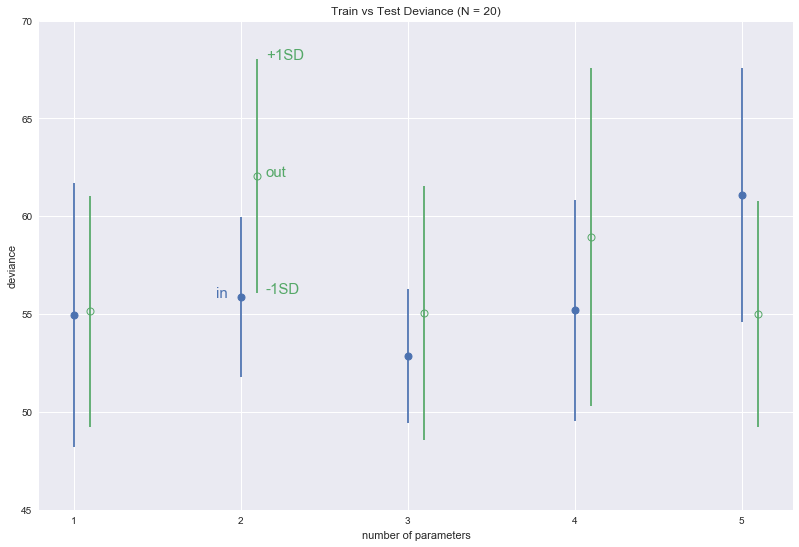

In [17]:
data = (pd.DataFrame(deviances, columns=["k", "dev_train", "dev_test"])
        .groupby("k")
        .agg({"dev_train": [np.mean, np.std],
              "dev_test": [np.mean, np.std]}))

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.errorbar(x=data.index, y=data["dev_train", "mean"], fmt="o", yerr=data["dev_train", "std"],
           mew=1.0, mec="C0");
ax.errorbar(x=data.index +0.1, y=data["dev_test", "mean"], fmt="o", yerr=data["dev_test", "std"],
           mew=1.0, mec="C1", mfc="None");
ax.set_xlabel("number of parameters")
ax.set_ylabel("deviance")
ax.set_title("Train vs Test Deviance (N = 20)")
plt.text(2 - 0.15, data.loc[2]["dev_train", "mean"], "in", color="C0", fontsize=15)
plt.text(2 + 0.15, data.loc[2]["dev_test", "mean"], "out", color="C1", fontsize=15)
plt.text(2 + 0.15, data.loc[2]["dev_test", "mean"] + data.loc[2]["dev_test", "std"],
         "+1SD", color="C1", fontsize=15)
plt.text(2 + 0.15, data.loc[2]["dev_test", "mean"] - data.loc[2]["dev_test", "std"],
         "-1SD", color="C1", fontsize=15)
ax.set_ylim(45, 70);

## Regularization

## Information Criteria

### 6.15

In [18]:
cars = pd.read_csv('Data/cars.csv', sep=',')

with pm.Model() as m6_9:
    sigma = pm.Uniform("sigma", 0, 30)
    b = pm.Normal("b", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + b*cars["speed"])
    dist = pm.Normal("dist", mu=mu, sd=sigma, observed = cars["dist"])
    trace6_9 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 945.24draws/s] 


### 6.16

In [19]:
n_samples = 1000

acc = []
for _ in range(n_samples):
    mu = trace6_9["a"][0] + trace6_9["b"][0]*cars["speed"]
    sigma = trace6_9["sigma"][0]
    acc.append(stats.norm.logpdf(cars["dist"], loc=mu, scale=sigma))
ll = np.array(acc)

### 6.17

In [20]:
n_cases = len(cars)
lppd = logsumexp(ll, axis=0) - np.log(n_samples)

### 6.18

In [21]:
pWAIC = np.var(ll, axis=0)

### 6.19

In [22]:
-2 * (sum(lppd) - sum(pWAIC))

416.98306088932816

### 6.20

In [23]:
waic_vec = -2 * (lppd - pWAIC)
np.sqrt(n_cases * np.var(waic_vec))

10.512566546324695

## Using Information Criteria

### 6.21

In [24]:
d = (pd.read_csv("Data/milk.csv", sep=";")
     .dropna())
d["neocortex"] = d["neocortex.perc"]/100
d.shape

(17, 9)

### 6.22

I'll be using the priors defined in [code block 14](https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_06.ipynb)

In [25]:
a_start = d["kcal.per.g"].mean()
sigma_start = d["kcal.per.g"].std()

# Create shared variables that can be set later, used in 6.29
model_logmass = theano.shared(np.log(d['mass'].values))
model_neocortex = theano.shared(d['neocortex'].values)

with pm.Model() as m6_11:
    sigma = pm.HalfCauchy("sigma", beta=10, testval=sigma_start)
    a = pm.Normal("a", mu=0, sd=10, testval=a_start)
    mu = pm.Deterministic("mu", a + 0*model_logmass) # Keep dimensions consistent
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace6_11 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m6_12:
    sigma = pm.HalfCauchy("sigma", beta=10, testval=sigma_start)
    a = pm.Normal("a", mu=0, sd=10, testval=a_start)
    bn = pm.Normal("bn", mu=0, sd=10)
    mu = pm.Deterministic("mu", a + bn*model_neocortex)
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace6_12 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m6_13:
    sigma = pm.HalfCauchy("sigma", beta=10, testval=sigma_start)
    a = pm.Normal("a", mu=0, sd=10, testval=a_start)
    bm = pm.Normal("bm", mu=0, sd=10)
    mu = pm.Deterministic("mu", a + bm*model_logmass)
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace6_13 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m6_14:
    sigma = pm.HalfCauchy("sigma", beta=10, testval=sigma_start)
    a = pm.Normal("a", mu=0, sd=10, testval=a_start)
    bn = pm.Normal("bn", mu=0, sd=10)
    bm = pm.Normal("bm", mu=0, sd=10)
    mu = pm.Deterministic("mu", a + bn*model_neocortex + bm*model_logmass)
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace6_14 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1940.72draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bn, a, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:10<00:00, 369.45draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bm, a, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1403.75draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bm, bn, a, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:16<00:0

### 6.23

In [26]:
pm.waic(trace6_14, m6_14)

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=-17.339821812378307, WAIC_se=4.84543348919888, p_WAIC=2.8164515575899225, var_warn=1)

### 6.24

In [27]:
milk_models = (pm.compare({m6_11 : trace6_11,
                           m6_12 : trace6_12,
                           m6_13 : trace6_13,
                           m6_14 : trace6_14},
                          method='pseudo-BMA')
               .join(pd.Series(["m6_11", "m6_12", "m6_13", "m6_14"], name="model"))
               .set_index("model")
               .sort_values("WAIC"))
milk_models

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m6_14,-17.34,2.82,0,0.97,4.85,0,1
m6_13,-8.96,2,8.38,0.01,4.09,3.31,1
m6_11,-8.92,1.24,8.42,0.01,3.57,4.65,0
m6_12,-6.89,2.07,10.45,0.01,3.24,4.7,0


### 6.25

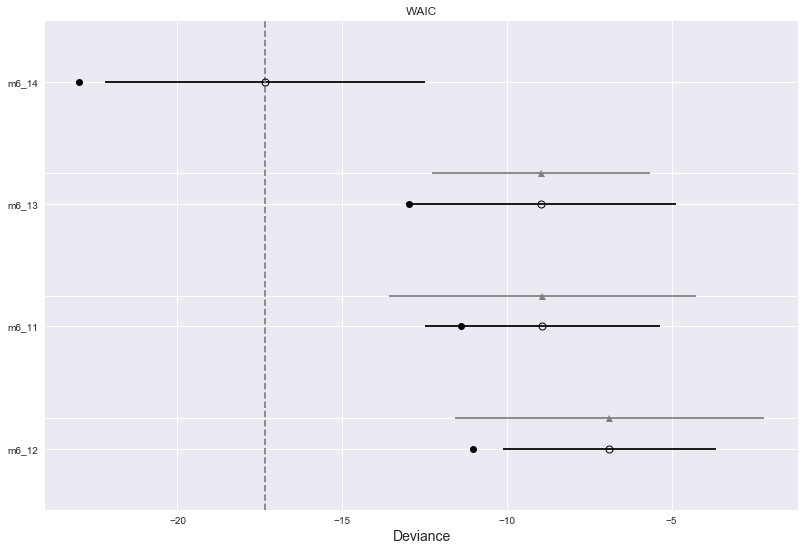

In [28]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
pm.compareplot(milk_models, ax=ax)
ax.set_title("WAIC");

### 6.26

In [29]:
diff = stats.norm.rvs(loc=milk_models.loc["m6_11", "dWAIC"], 
                      scale=milk_models.loc["m6_11", "dSE"], 
                      size=int(1e5))
sum(diff < 0)/1e5

0.03537

### 6.27

In [30]:
summaries = [("m6_11", pm.summary(trace6_11, alpha=0.11, varnames=["a", "sigma"])),
             ("m6_12", pm.summary(trace6_12, alpha=0.11, varnames=["a", "bn", "sigma"])),
             ("m6_13", pm.summary(trace6_13, alpha=0.11, varnames=["a", "bm", "sigma"])),
             ("m6_14", pm.summary(trace6_14, alpha=0.11, varnames=["a", "bn", "bm", "sigma"]))]

coeftab = (pd.concat([summary.reset_index().assign(model=model) for (model, summary) in summaries])
           .rename(columns={"index": "parameter"})
           .set_index(["parameter", "model"]))

(coeftab
 .reset_index()
 .pivot_table(index="parameter", columns="model", values="mean"))

model,m6_11,m6_12,m6_13,m6_14
parameter,,,,
a,0.656123,0.402299,0.706387,-1.082131
bm,NaN,NaN,-0.032233,-0.096091
bn,NaN,0.377608,NaN,2.786186
sigma,0.187414,0.192421,0.183091,0.139773


### 6.28

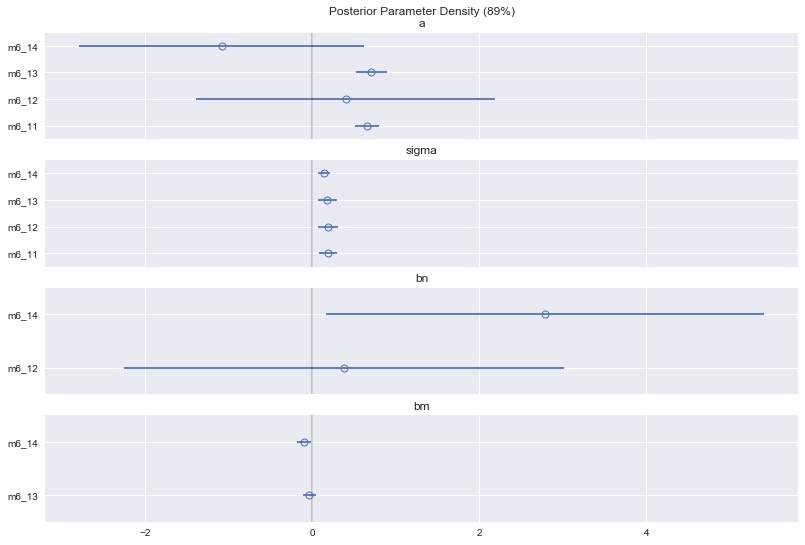

In [31]:
f, axs = plt.subplots(4, 1, sharex=True)
f.set_size_inches(13.5, 9)
data = (coeftab[["mean", "hpd_5.5", "hpd_94.5"]])

axs[0].errorbar(data.loc["a"]["mean"], data.loc["a"].index, fmt="o", 
                xerr=data.loc["a"]["hpd_94.5"] - data.loc["a"]["hpd_5.5"], 
                mew=1, mfc="None")
axs[0].vlines(0, ymin=-1, ymax=4, alpha=0.2)
axs[0].set_ylim(-0.5, 3.5)
axs[0].set_title("Posterior Parameter Density (89%)\n"
                 "a")

axs[1].errorbar(data.loc["sigma"]["mean"], data.loc["sigma"].index, fmt="o", 
                xerr=data.loc["sigma"]["hpd_94.5"] - data.loc["sigma"]["hpd_5.5"], 
                mew=1, mfc="None")
axs[1].vlines(0, ymin=-1, ymax=4, alpha=0.2)
axs[1].set_ylim(-0.5, 3.5)
axs[1].set_title("sigma")

axs[2].errorbar(data.loc["bn"]["mean"], data.loc["bn"].index, fmt="o", 
                xerr=data.loc["bn"]["hpd_94.5"] - data.loc["bn"]["hpd_5.5"], 
                mew=1, mfc="None")
axs[2].vlines(0, ymin=-1, ymax=2, alpha=0.2)
axs[2].set_ylim(-0.5, 1.5)
axs[2].set_title("bn")

axs[3].errorbar(data.loc["bm"]["mean"], data.loc["bm"].index, fmt="o", 
                xerr=data.loc["bm"]["hpd_94.5"] - data.loc["bm"]["hpd_5.5"], 
                mew=1, mfc="None")
axs[3].vlines(0, ymin=-1, ymax=2, alpha=0.2)
axs[3].set_ylim(-0.5, 1.5)
axs[3].set_title("bm");

### 6.29

100%|██████████| 10000/10000 [00:01<00:00, 7995.96it/s]


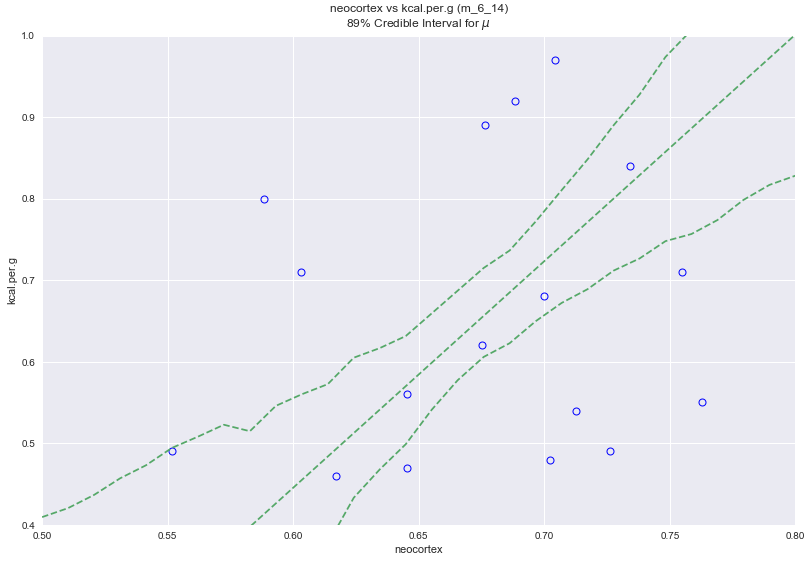

In [32]:
nc_seq = np.linspace(0.5, 0.8, 30)
mass = np.repeat(4.5, 30)

model_neocortex.set_value(nc_seq)
model_logmass.set_value(np.log(mass))
post_pred = pm.sample_ppc(trace6_14, samples=10000, model=m6_14, vars=[m6_14.mu])["mu"]

mu = post_pred.mean(axis=0)
mu_pi = pm.hpd(post_pred, alpha=0.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(d["neocortex"], d["kcal.per.g"], "o", mew=1, mec="b", mfc="None")
ax.plot(nc_seq, mu, "--", color="C1")
ax.plot(nc_seq, mu_pi[:, 0], "--", color="C1")
ax.plot(nc_seq, mu_pi[:, 1], "--", color="C1")
ax.set_xlim((0.5, 0.8))
ax.set_ylim((0.4, 1.0))
ax.set_title("neocortex vs kcal.per.g (m_6_14)\n"
             "89% Credible Interval for $\mu$")
ax.set_xlabel("neocortex")
ax.set_ylabel("kcal.per.g");

### 6.30

`pm.sample_ppc_w` does work for weighted predictions but since it doesn't have a `vars` parameter it can't be used in this situation.

In [33]:
models = {"m6_11": {"trace": trace6_11,
                    "model": m6_11,
                    "weight": milk_models.loc["m6_11"]["weight"]},
          "m6_12": {"trace": trace6_12,
                    "model": m6_12,
                    "weight": milk_models.loc["m6_12"]["weight"]},
          "m6_13": {"trace": trace6_13,
                     "model": m6_13,
                     "weight": milk_models.loc["m6_13"]["weight"]},
          "m6_14": {"trace": trace6_14,
                     "model": m6_14,
                     "weight": milk_models.loc["m6_14"]["weight"]}}

In [34]:
num_samples = 10000

acc = []
for (_, mdata) in models.items():
    pred = pm.sample_ppc(mdata["trace"], 
                         samples=int(mdata["weight"]*num_samples),
                         model=mdata["model"],
                         vars=[mdata["model"].mu])
    acc.append(pred["mu"])
wmu_pred = np.vstack(acc)

100%|██████████| 9700/9700 [00:01<00:00, 7969.91it/s]


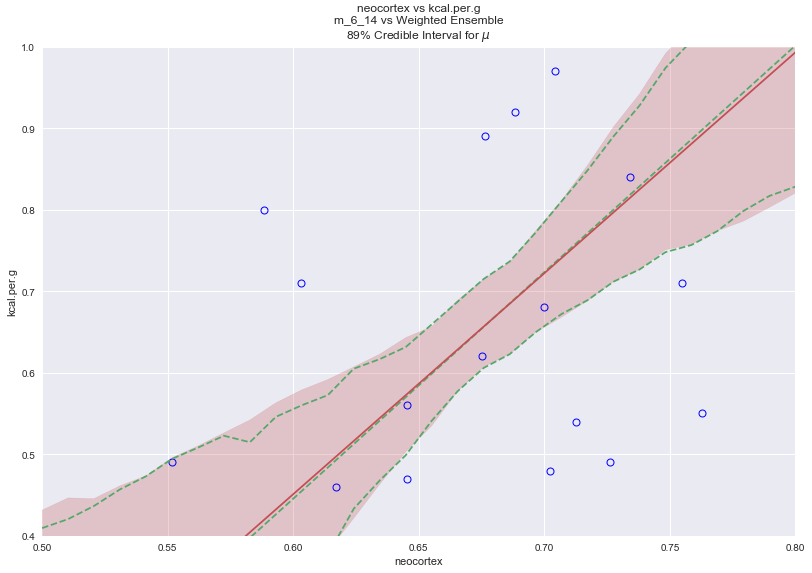

In [35]:
mu = post_pred.mean(axis=0)
mu_pi = pm.hpd(post_pred, alpha=0.11)
wmu = wmu_pred.mean(axis=0)
wmu_pi = pm.hpd(wmu_pred, alpha=0.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(d["neocortex"], d["kcal.per.g"], "o", mew=1, mec="b", mfc="None")

ax.plot(nc_seq, mu, "--", color="C1")
ax.plot(nc_seq, mu_pi[:, 0], "--", color="C1")
ax.plot(nc_seq, mu_pi[:, 1], "--", color="C1")

ax.plot(nc_seq, wmu, color="C2")
ax.fill_between(nc_seq, wmu_pi[:,0], wmu_pi[:,1], alpha=0.25, color="C2")

ax.set_xlim((0.5, 0.8))
ax.set_ylim((0.4, 1.0))
ax.set_title("neocortex vs kcal.per.g\n"
             "m_6_14 vs Weighted Ensemble\n"
             "89% Credible Interval for $\mu$")
ax.set_xlabel("neocortex")
ax.set_ylabel("kcal.per.g");